In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# code to make tensors run on GPU
def set_gpu_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Calling the function to set GPU device
set_gpu_device()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("No GPU found. TensorFlow will use the CPU.")

GPU is available!


In [2]:
# seting path to the dataset
train_data = pathlib.Path('new_dataset/train/')
test_data = pathlib.Path('new_dataset/test/')
valid_data = pathlib.Path('new_dataset/valid/')

In [3]:
# defining image generator
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    # horizontal_flip = True,
    fill_mode = 'nearest',
)

#* Leaving this image generator empty as we are only agumenting train data
test_gen = ImageDataGenerator()
valid_gen = ImageDataGenerator()

#! I dont know why he was changing these parameters with mean
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_gen.mean = mean
valid_gen.mean = mean
test_gen.mean = mean

In [4]:
batch_size = 32


#  creating a generator for train.
train = train_gen.flow_from_directory(
    train_data,
    class_mode = "categorical",
    target_size =(244,244),
    color_mode = 'rgb',
    shuffle=True,
    batch_size = batch_size,
)

test = test_gen.flow_from_directory(
    test_data,
    class_mode = "categorical",
    target_size =(244,244),
    color_mode = 'rgb',
    shuffle=True,
    batch_size = batch_size,
)

val = valid_gen.flow_from_directory(
    valid_data,
    class_mode = "categorical",
    target_size =(244,244),
    color_mode = 'rgb',
    shuffle=True,
    batch_size = batch_size,
)

Found 7657 images belonging to 14 classes.
Found 3029 images belonging to 14 classes.
Found 3020 images belonging to 14 classes.


In [5]:
# #VGG16 = keras.applications.vgg16
# from keras.layers import Input
# from keras.applications import VGG16
# from keras.models import Model
# from keras.optimizers import SGD

# baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# # construct the head of the model that will be placed on top of the
# # the base model

# # Freeze four convolution blocks
# for layer in baseModel.layers [:-5]: #! Decreased the unfreezed layers form 15 to -5
#     layer.trainable = False
    
# headModel = baseModel.output
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(256, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(256, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(14, activation="softmax")(headModel)
# # place the head FC model on top of the base model (this will become
# # the actual model we will train)
# model = Model(inputs=baseModel.input, outputs=headModel)

# model.summary() 

# # Make sure you have frozen the correct layers
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

## MODIFIED 

In [6]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.models import Model
from keras.optimizers import SGD

# Load the VGG16 model with pre-trained weights
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the convolutional base
for layer in baseModel.layers:
    layer.trainable = False

# Create the top layers for custom classification
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel) 
headModel = Dropout(0.5)(headModel)
headModel = Dense(1024, activation="relu")(headModel) 
headModel = Dropout(0.5)(headModel)
headModel = Dense(14, activation="softmax")(headModel)  # Adjusting the number of output classes (14 in this example)

# Create the final model
model = Model(inputs=baseModel.input, outputs=headModel)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=1e-4, momentum=0.9), metrics=["accuracy"])

# Display the model summary
model.summary()

# # Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

c:\Users\sudha\py10\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:

totalTrain=5006
totalVal=1000
print("compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
# model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["acc"])
# Model Compilation with Binary Cross-Entropy Loss
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])


# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("training head...")
H = model.fit(
    x=train,
    # steps_per_epoch=totalTrain // batch_size,
    steps_per_epoch=len(train),
    validation_data=val,
    validation_steps=len(val),
    # validation_steps=totalVal // batch_size,
    epochs=100)


compiling model...


c:\Users\sudha\py10\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


training head...
Epoch 1/100
240/240 [==============================] - 220s 870ms/step - loss: 7.5648 - acc: 0.3917 - val_loss: 0.9470 - val_acc: 0.7632
Epoch 2/100
240/240 [==============================] - 159s 661ms/step - loss: 2.1883 - acc: 0.5181 - val_loss: 0.8372 - val_acc: 0.7752
Epoch 3/100
240/240 [==============================] - 157s 653ms/step - loss: 1.7376 - acc: 0.5643 - val_loss: 0.6918 - val_acc: 0.7934
Epoch 4/100
240/240 [==============================] - 159s 662ms/step - loss: 1.4743 - acc: 0.6056 - val_loss: 0.6428 - val_acc: 0.8139
Epoch 5/100
240/240 [==============================] - 161s 669ms/step - loss: 1.3532 - acc: 0.6328 - val_loss: 0.5694 - val_acc: 0.8298
Epoch 6/100
240/240 [==============================] - 162s 677ms/step - loss: 1.2136 - acc: 0.6624 - val_loss: 0.5294 - val_acc: 0.8497
Epoch 7/100
240/240 [==============================] - 267s 1s/step - loss: 1.1422 - acc: 0.6756 - val_loss: 0.5043 - val_acc: 0.8566
Epoch 8/100
240/240 [======

In [8]:
model.save("vgg14.keras", save_format="keras")

In [9]:
target_names = []
for key in train.class_indices:
    target_names.append(key)
    
print(target_names)

['Amur_Leopard', 'Arctic_Fox', 'Chimpanzee', 'Jaguars', 'Lion', 'Orangutan', 'Panda', 'Panthers', 'Rhino', 'belgua', 'cheetahs', 'heyna', 'leopard', 'whaleshark']


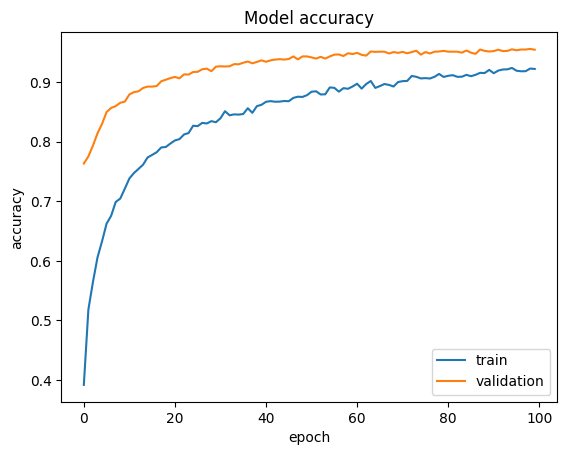

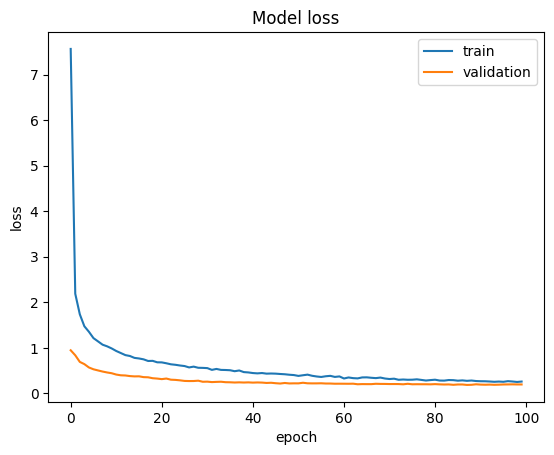

In [10]:
############################################
#Plot the Graph

acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')
plt.show()

In [15]:
# evaluating the performance of the model on a test dataset.
test_loss, test_acc = model.evaluate(test)
val_loss, val_acc = model.evaluate(val)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")

95/95 [==============================] - 27s 278ms/step - loss: 0.1963 - acc: 0.9543
Test accuracy: 96.27%
Validation accuracy: 95.43%


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
y_pred = model.predict(test)
y_predict =  np.argmax(y_pred, axis =1)
y_true = test.classes

conf_matrix = confusion_matrix(y_true,y_predict)
class_report = classification_report(y_true, y_predict, target_names=test.class_indices.keys())
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

95/95 [==============================] - 29s 301ms/step
Confusion Matrix:
 [[13  3  8 13 18 16 16 14 23 13 18 14 15 15]
 [ 9  6  8  5 12  7 14 11 14 16 10  8  8  7]
 [ 6  5 12 18 13 11 20 12  6 10 10 13 15 15]
 [14  8  5 19 21  8 19 13 16 16 23 16 16 15]
 [ 6 16 17 24 26 17 23 23 20 15 21 24 20 19]
 [12 10 14  9 13 14 16 16 13 11  6 10 17 18]
 [11 11 13 19 26 19 29 20 27 19 17 23 21 25]
 [14 12 13 15 21  9 17 11 13 14 10 19 15 17]
 [12  6 17 18 23 18 18 13 31 27 13 19 22 22]
 [13 17  9 20 23 14 26 17 11 18 20 10 13 19]
 [22  8  7 14 16 11 22  7 16 21 21 16 11 19]
 [15  9 20 20 16 10 22 16 18 15 16 18 19 16]
 [17 16 11 15 23  7 21  7 29 20 19 15 17 13]
 [14  7 12 14 19 17 15 20 27 15 14 19 25 12]]

Classification Report:
               precision    recall  f1-score   support

Amur_Leopard       0.07      0.07      0.07       199
  Arctic_Fox       0.04      0.04      0.04       135
  Chimpanzee       0.07      0.07      0.07       166
     Jaguars       0.09      0.09      0.09       20

Confusion matrix, without normalization


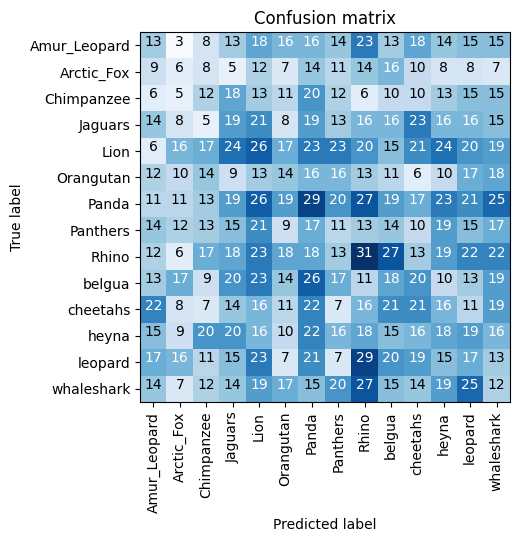

In [22]:
import itertools 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix of snake Vs background', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#thresh = cm.max() / 2.
#Matplotlib’s matshow
cm = confusion_matrix(y_true,y_predict)

plt.figure(3)
plot_confusion_matrix(cm, target_names, title='Confusion matrix')
#print(cm)
plt.savefig('VGG16.png')
plt.show()

The metrics and information provided suggest that the model has certain strengths and weaknesses. Let's break down the evaluation:

1. **Accuracy**: The model achieves an accuracy of 96.27% on the test dataset and 95.43% on the validation dataset. This indicates that the model is making correct predictions for the majority of the samples.

2. **Confusion Matrix**: The confusion matrix provides a breakdown of the model's predictions for each class. It shows how many true positives, true negatives, false positives, and false negatives the model produced for each class. It can help you understand which classes the model is performing well on and where it may be making errors.

3. **Classification Report**: The classification report provides metrics for each class, including precision, recall, and F1-score. These metrics help you understand how well the model is performing for each class. 

Here are some observations:

- Precision, Recall, and F1-score for each class are generally low, with values around 0.07 to 0.10. This suggests that the model may have difficulty distinguishing between different classes, and there might be a fair amount of misclassification.

- The "macro avg" and "weighted avg" values for precision, recall, and F1-score are all around 0.08. These values consider the average performance across all classes. The "macro avg" treats all classes equally, while the "weighted avg" considers class imbalances. 

In summary, the model has achieved a high overall accuracy, but the low precision, recall, and F1-score for individual classes indicate that the model may not perform well for specific classes. Whether this model is "good" depends on the specific use case and requirements:

- If high accuracy across all classes is critical, the model may need further improvement, particularly for those classes with low precision and recall.

- If the model's primary task is to recognize a few key classes and accuracy for other classes is less important, then the model might be considered acceptable, as long as it performs well on those key classes.

It's important to consider the practical implications of the model's performance and the specific goals of your project. Further model optimization and tuning may be necessary to improve its performance on individual classes if needed.